In [57]:
#All liberies
from numba import njit
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import lil_matrix, issparse, csr_matrix
from tqdm import tqdm
from sys import getsizeof
from scipy.sparse.linalg import eigsh
import h5py
import os
from pympler import asizeof

In [58]:
def rotate_vec(vector, n):
    rotation_matrices = {
        0: np.array([[1, 0], [0, 1]]),    # 0 degrees
        1: np.array([[0, -1], [1, 0]]),   # 90 degrees
        2: np.array([[-1, 0], [0, -1]]),  # 180 degrees
        3: np.array([[0, 1], [-1, 0]])    # 270 degrees
    }
    
    roated_vector = rotation_matrices[n] @ vector
    return roated_vector


def segment_point(p1,p2):
    v1 = np.array(np.array(p2)-np.array(p1))
    relative_length = np.linalg.norm(v1)/4
    v1 = v1/np.linalg.norm(v1)
    angle = np.arctan2(v1[1], v1[0])
    angle_degrees = np.degrees(angle)
    angle_degrees = angle_degrees % 360
    n = round(angle_degrees / 90) % 4
    vectors_list = [[relative_length, 0.0], 
                    [0.0, relative_length], 
                    [relative_length, 0.0], 
                    [0.0, -relative_length], 
                    [0.0, -relative_length], 
                    [relative_length, 0.0], 
                    [0.0, relative_length]]
    point = np.array(p1)
    points_list = [p1]
    for vectors in vectors_list:
        roatated_vec = rotate_vec(vectors,n)
        point = point + roatated_vec
        points_list.append(np.round(point).tolist())
    return points_list

def new_line(line):
    new_line = []
    for i in range(0,len(line)-1):
        segment_points = segment_point(line[i], line[i+1]) 
        new_line = new_line + segment_points
    new_line.append(line[-1])
    return new_line

def fract(l, line):
    for _i in range(0,l):
        line = new_line(line)
    return line

def plotting_line(l, size):
    line = [[0.0,0.0], [size,0.0]]
    for i in range(0,l+1):
        line = fract(i,line)
        x_cords = [i[0] for i in line]
        y_cords = [i[1] for i in line]
        plt.plot(x_cords,y_cords)
    plt.show()

def plotting_square(l,size):
    for i in range(0,l+1):
        total_points = generate_square_without_shift(i, size)
        x_cords = [i[0] for i in total_points]
        y_cords = [i[1] for i in total_points]
        plt.plot(x_cords,y_cords)
    plt.show()


def generate_square_without_shift(l,size):
    lines = [
        [[0.0, 0.0], [size, 0.0]],  
        [[size, 0.0], [size, size]],
        [[size, size], [0.0, size]],
        [[0.0, size], [0.0, 0.0]]
        ]
    total_points = []
    for line in lines:
        line = fract(l,line)
        total_points = total_points + line
    min_x = min([i[0] for i in total_points])
    min_y = min([i[1] for i in total_points])
    print(min_x,min_y)
    total_points = [i + [min_x,min_y] for i in total_points]
    return total_points

    
def generate_square(l, size):
    lines = [
        [[0.0, 0.0], [size, 0.0]],  
        [[size, 0.0], [size, size]],
        [[size, size], [0.0, size]],
        [[0.0, size], [0.0, 0.0]]
    ]
    
    total_points = []
    
    for line in lines:
        line_points = fract(l, line)  
        total_points.extend(line_points)  

    min_x = min(point[0] for point in total_points)
    min_y = min(point[1] for point in total_points)

    adjusted_points = np.array([[point[0] - min_x, point[1] - min_y] for point in total_points])
    return adjusted_points


0.0 0.0
-16.0 -16.0
-20.0 -20.0
-21.0 -21.0


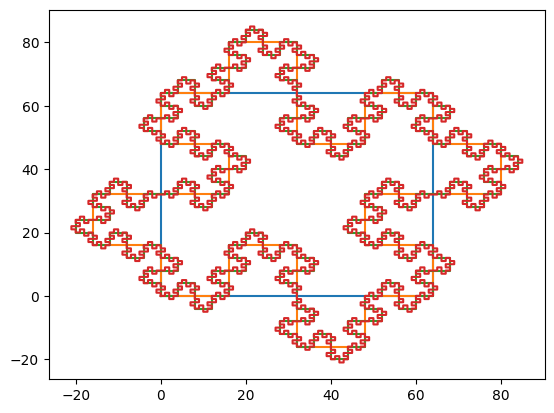

In [59]:
plotting_square(3,4**3)

In [60]:
def does_intersect(x1,x2,point):
    if x1[1] > x2[1]:
        x1, x2 = x2, x1
        
    if x1[1] <= point[1] < x2[1]: 
        x_intersect = (point[1] + 0.001 - x1[1]) * (x2[0] - x1[0]) / (x2[1] - x1[1]) + x1[0]
        return x_intersect > point[0] 
    return False


def in_boundry(point,boundry): 
    boundry = np.array(boundry)   
    n = len(boundry)
    num_of_intersect = 0

    if np.any(np.all(boundry == point, axis=1)):
            return False

    for i in range(n):
        p1 = boundry[i]
        p2 = boundry[(i+1)%n]
        if does_intersect(p1,p2, point):
            num_of_intersect +=1
    return num_of_intersect % 2 == 1

def in_boundry_vecotrized(points, boundry):
    boundry = np.array(boundry)
    n = len(boundry)
    num_of_intersect = np.zeros(len(points), dtype=int)

    for i in range(n):
        p1 = boundry[i]
        p2 = boundry[(i + 1) % n]
        intersects = np.array([does_intersect(p1, p2, point) for point in points])
        num_of_intersect += intersects

    return num_of_intersect % 2 == 1

In [61]:
def generate_grid(l):
    size = max((4**l, 4**3))
    boundry = generate_square(l, size)
    x_boundry = np.array([i[0] for i in boundry])
    y_boundry = np.array([i[1] for i in boundry])
    min_x = int(np.min(x_boundry))
    max_x = int(np.max(x_boundry))
    min_y = int(np.min(y_boundry))
    max_y = int(np.max(y_boundry))
    grid_x = np.arange(min_x, max_x)
    grid_y = np.arange(min_y, max_y)
    grid = np.array([[x, y] for y in grid_y for x in grid_x])
    grid_z = np.array([in_boundry(point, boundry) for point in grid])
    grid = np.array([[point[0],point[1], in_boundry] for point, in_boundry  in zip(grid, grid_z)])
    return grid, boundry

In [62]:
#From julia
grids = []
boundries = []


# Loop to read multiple HDF5 files
for i in range(1, 6):
    file_path = os.path.join(os.getcwd(), f'HDF5_files/grid_boundary{i}.h5')
    try:
        with h5py.File(file_path, 'r') as f:
            grids.append(f['grid'][:])
            boundries.append(f['boundary'][:])
    except FileNotFoundError:
        print(f"File {file_path} not found. Please ensure the file exists.")

# Print the first grid
if not grids:
    print("No grids loaded.")
print(grids[0][32*50-16])
print(boundries[0][1])

[32. 16.  0.]
[32. 16.]


[]


[[array([61.,  0.,  1.]), 61, None],
 [array([62.,  0.,  1.]), 62, None],
 [array([63.,  0.,  1.]), 63, None],
 [array([60.,  1.,  1.]), 165, None],
 [array([60.,  2.,  1.]), 270, None],
 [array([60.,  3.,  1.]), 375, None],
 [array([53.,  4.,  1.]), 473, None],
 [array([54.,  4.,  1.]), 474, None],
 [array([55.,  4.,  1.]), 475, None],
 [array([61.,  4.,  1.]), 481, None],
 [array([62.,  4.,  1.]), 482, None],
 [array([63.,  4.,  1.]), 483, None],
 [array([65.,  4.,  1.]), 485, None],
 [array([66.,  4.,  1.]), 486, None],
 [array([67.,  4.,  1.]), 487, None],
 [array([52.,  5.,  1.]), 577, None],
 [array([60.,  5.,  1.]), 585, None],
 [array([64.,  5.,  1.]), 589, None],
 [array([52.,  6.,  1.]), 682, None],
 [array([60.,  6.,  1.]), 690, None],
 [array([64.,  6.,  1.]), 694, None],
 [array([52.,  7.,  1.]), 787, None],
 [array([60.,  7.,  1.]), 795, None],
 [array([64.,  7.,  1.]), 799, None],
 [array([49.,  8.,  1.]), 889, None],
 [array([50.,  8.,  1.]), 890, None],
 [array([51.,  

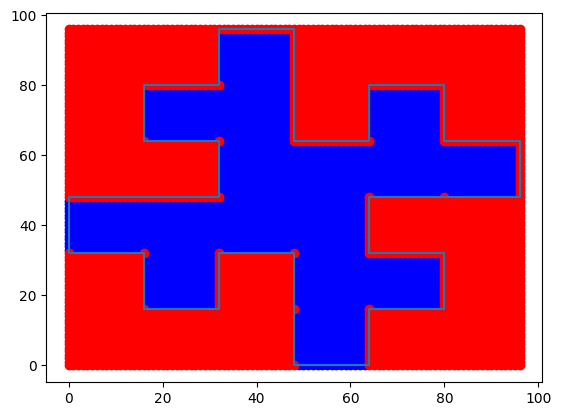

In [63]:
def plotting_grid(grid, boundry):
    grid_1 = [i for i in grid if i[2] == 1]
    grid_2 = [i for i in grid if i[2] == 0]
    x_points_outside = [i[0] for i in grid_2]
    y_points_outside = [i[1] for i in grid_2]
    x_points = [i[0] for i in grid_1]
    y_points = [i[1] for i in grid_1]
    x_boundary = boundry[:,0]
    y_boundary = boundry[:,1]
    plt.scatter(x_points,y_points, color= "b")
    plt.scatter(x_points_outside, y_points_outside, color="r")
    plt.plot(x_boundary,y_boundary)
plotting_grid(grids[0],boundries[0])

def find_failures(grid, boundary):
    failures = []
    for index, point in enumerate(grid):
        if point[:2] in boundary and point[2] == 1:
            try:
                boundary_index = list(boundary).index(point[:2])
                failures.append([point, index, boundary_index])
            except ValueError:
                # Handle the case where point[:2] is not found in boundary
                failures.append([point, index, None])
    failures_with_index = [i for i in failures if i[2] != None] 
    print(failures_with_index)
    return failures

find_failures(grids[1], boundries[1])


In [64]:
def discrete_laplacian(vector_length, row_length):
    total_array = []
    for i in range(vector_length):
        new_array = np.zeros(vector_length)
        
        next_x = i + 1
        next_y = i + row_length
        previous_x = i - 1
        previous_y = i - row_length
        
        if next_x < vector_length and (i % row_length) < (row_length - 1):
            new_array[next_x] = -1
        if next_y < vector_length and (i // row_length) < (row_length - 1):
            new_array[next_y] = -1
        if previous_x >= 0 and (i % row_length) > 0:  
            new_array[previous_x] = -1
        if previous_y >= 0 and (i // row_length) > 0: 
            new_array[previous_y] = -1
        
        new_array[i] = 4 
        total_array.append(new_array)
    
    return np.array(total_array), row_length

def sparse_discrete_laplacian(vector_length, row_length, grid):
    laplacian_matrix = lil_matrix((vector_length, vector_length))
    if vector_length != row_length**2:
        print("Wrong vector or row length there should be a quadratic relationship between the two")
        raise ValueError
    for index, point in enumerate(grid):
        if point[2] == 1:
            next_x = index + 1
            next_y = index + row_length
            previous_x = index - 1
            previous_y = index - row_length

            if next_x < vector_length and index % row_length != 0 and grid[next_x, 2] == 1:
                laplacian_matrix[index, next_x] = -1
            if next_y < vector_length and (index // row_length) < (row_length - 1) and grid[next_y, 2] == 1:
                laplacian_matrix[index, next_y] = -1
            if previous_x >= 0 and (index % row_length) > 0 and grid[previous_x, 2] == 1:
                laplacian_matrix[index, previous_x] = -1
            if previous_y >= 0 and grid[previous_y, 2] == 1:
                laplacian_matrix[index, previous_y] = -1

            laplacian_matrix[index, index] = 4

    return laplacian_matrix.tocsr()



$dd = \frac{U_{n-1,m} + U_{n+1,m} + U_{n,m-1} + U_{n,m-1} - 4U_{n,m}}{h^2} $ 

In [65]:
def find_ram_procentage(laplacian):
    total_ram = 15.7*10**9
    procent_of_ram = asizeof.asizeof(laplacian) / total_ram * 100
    return procent_of_ram


In [66]:
grid_3 = grids[2]
x_collum = grid_3[:,0]

print(len(x_collum))
print(len(grid_3))
sparse_laplacian = sparse_discrete_laplacian(len(grid_3),len(set(x_collum)), grid_3)
normal_laplacian = discrete_laplacian(len(grid_3), len(x_collum))
normal_ram = find_ram_procentage(normal_laplacian)
sparse_ram = find_ram_procentage(sparse_laplacian)
print("Normal matrix ram usage: ", normal_ram, " vs Sparse matrix ram usage: ", sparse_ram)

11449
11449
Normal matrix ram usage:  6.679216815286624  vs Sparse matrix ram usage:  0.0024823949044585985


In [105]:
def find_eiegenvalues(laplacian, number_of_values = 300, what_values = "SA"):
    eigenvalues, eigenvectors = eigsh(laplacian, k=number_of_values, which=what_values, mode="cayley")
    return eigenvalues, eigenvectors

In [97]:
def plotting_eigenvectors_old(eigenvectors,boundry, number_values = 10):
    x_boundry = boundry[:,0]
    x_max = max(x_boundry)
    x_boundry = x_boundry/x_max
    y_boundry = boundry[:, 1]
    y_max = max(y_boundry)
    y_boundry = y_boundry/y_max


    max_dim = int(np.sqrt(len(eigenvectors[:,0])))

    for i in range(0,number_values):
        vibrations = eigenvectors[:, i].reshape(max_dim,max_dim)
        plt.imshow(vibrations, extent=(0, 1, 0, 1), origin='lower', cmap='viridis', aspect='auto')
        plt.plot(x_boundry,y_boundry, color="r")
        plt.show()

def plotting_eigenvectors(eigenvectors, boundry,plot_tittle, number_values = 10):
    x_boundry = boundry[:,0]
    x_max = max(x_boundry)
    x_boundry = x_boundry/x_max
    y_boundry = boundry[:, 1]
    y_max = max(y_boundry)
    y_boundry = y_boundry/y_max

    max_dim = int(np.sqrt(len(eigenvectors[:,0])))
    n_rows = int(np.ceil(np.sqrt(number_values)))
    n_cols = int(np.ceil(number_values / n_rows))

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*4))

    for i in range(0, number_values):
        vibrations = eigenvectors[:, i].reshape(max_dim, max_dim)
        row = i // n_cols
        col = i % n_cols
        if n_rows == 1:
            ax = axs[col]
        elif n_cols == 1:
            ax = axs[row]
        else:
            ax = axs[row, col]
        ax.imshow(vibrations, extent=(0, 1, 0, 1), origin='lower', cmap='viridis', aspect='auto')
        ax.plot(x_boundry, y_boundry, color="r")
        ax.set_title(f"Mode {i+1}")

    # Remove any unused subplots
    for i in range(number_values, n_rows*n_cols):
        row = i // n_cols
        col = i % n_cols
        if n_rows == 1:
            ax = axs[col]
        elif n_cols == 1:
            ax = axs[row]
        else:
            ax = axs[row, col]
        ax.axis('off')
    fig.suptitle(plot_tittle)
    plt.tight_layout()
    plt.show()


Done with laplacian
9.429937633273905


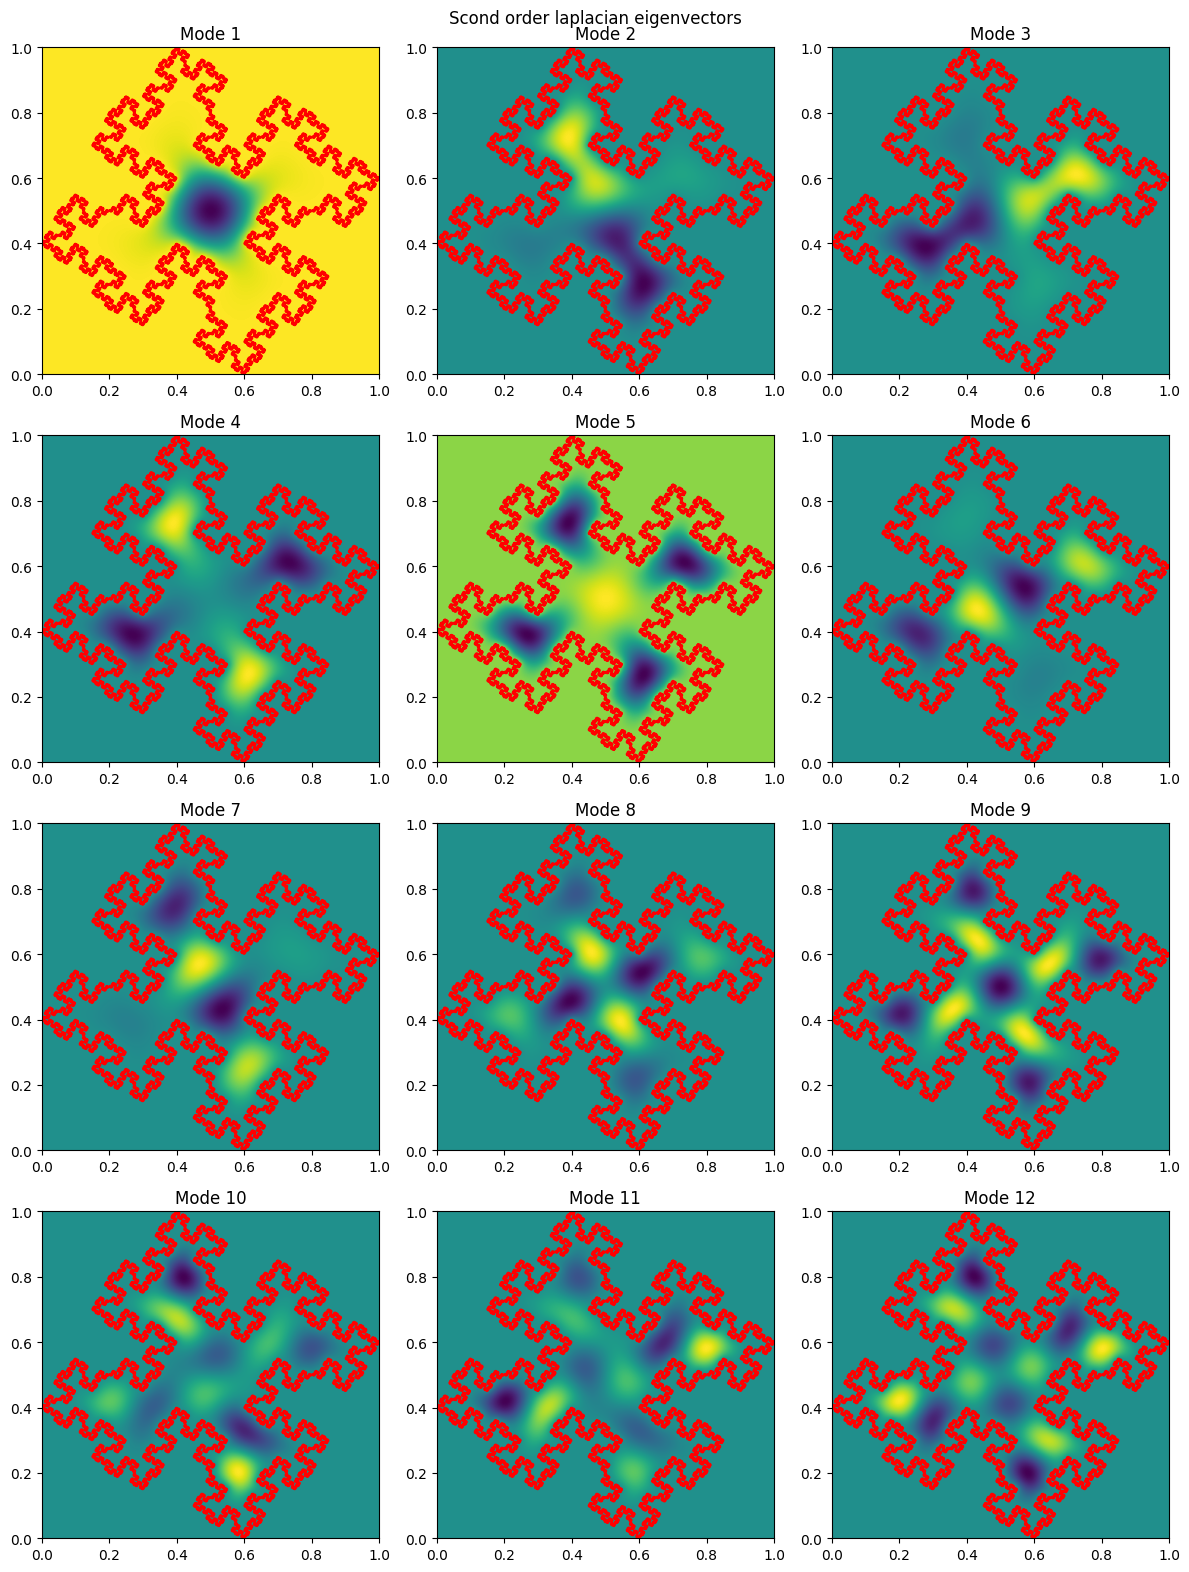

In [107]:
x_collum = grids[3][:,0]
grid_4 = grids[3]
lapliacian = sparse_discrete_laplacian(len(grid_4),len(set(x_collum))  , grid_4)
print("Done with laplacian")
eigenvalues, eigenvectors = find_eiegenvalues(lapliacian, 12)
print(4**4*np.sqrt(eigenvalues[0]))
plotting_eigenvectors(eigenvectors,boundries[3], "Scond order laplacian eigenvectors" , 12)

In [70]:
def finding_d(eigenvalues,l):
    eigenvalues_list = np.round(eigenvalues, 5)
    eigenvalues_set = list(set(eigenvalues_list))
    system_length = max(4**3,4**l)

    find_index = lambda x: list(eigenvalues_list).index(x)
    deltaN = [system_length**2*eig/(4*np.pi) - len(eigenvalues[:find_index(eig)])  for eig in eigenvalues_set]
    log_deltaN = [np.log(i) for i in deltaN]
    log_eigenvalues = [np.log(i)/2 for i in eigenvalues_set]

    plt.scatter(log_eigenvalues, log_deltaN)
    coefficients = np.polyfit(log_eigenvalues, log_deltaN, 1)
    f_x = lambda x: coefficients[0]*x+coefficients[1]
    v_f_x = np.vectorize(f_x)
    plt.plot (log_eigenvalues, v_f_x(log_eigenvalues), color="r")
    plt.title(f"Scaling of DeltaN for l={l} and {len(eigenvalues)} eigenvalues")
    plt.xlabel("Unique eigenvalues (w)")
    plt.ylabel("DeltaN")
    plt.show()
    scalar = coefficients[0]
    return scalar

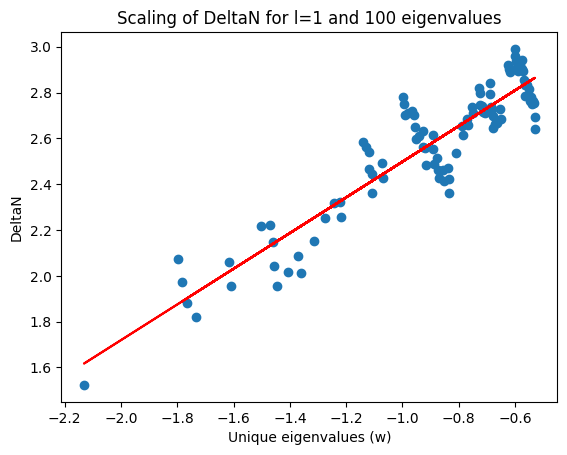

Scaling for l=1: 0.778829736215889


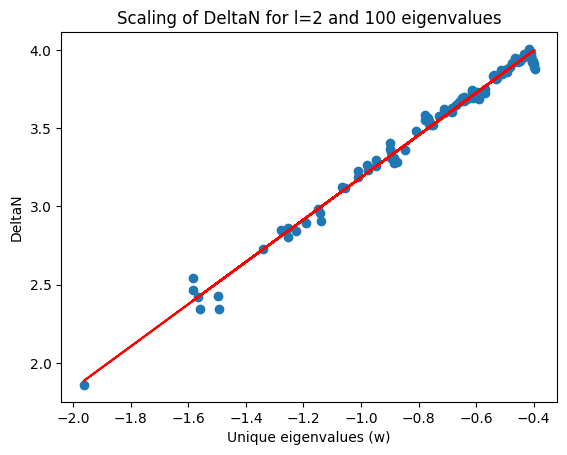

Scaling for l=2: 1.348963302758138


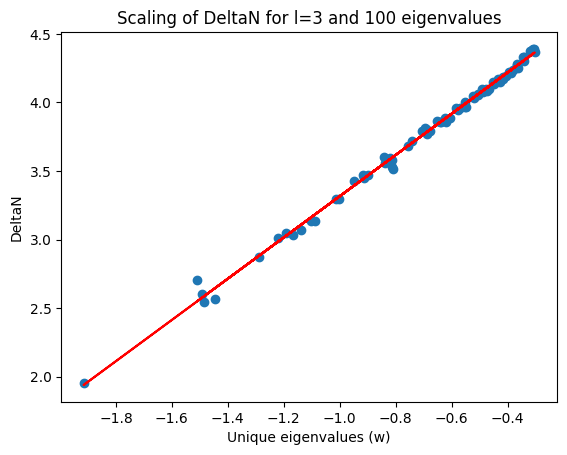

Scaling for l=3: 1.5041276649277049


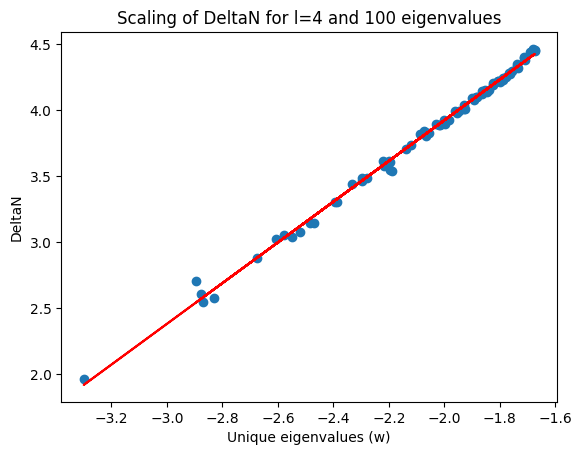

Scaling for l=4: 1.5420400652918593


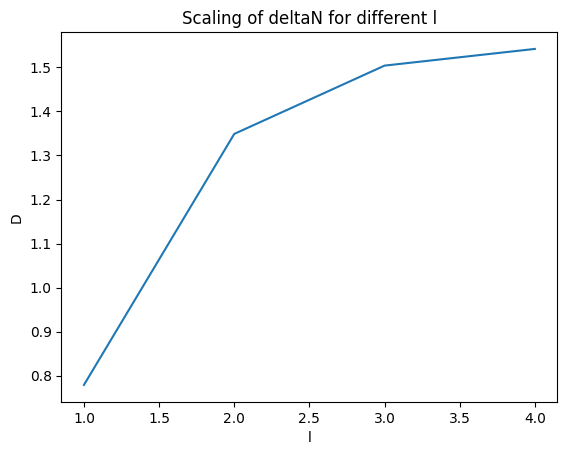

{1: np.float64(0.778829736215889), 2: np.float64(1.348963302758138), 3: np.float64(1.5041276649277049), 4: np.float64(1.5420400652918593)}


In [71]:
def find_scaling_for_different_l(l_values, grid_list, lapliacian_func=sparse_discrete_laplacian):
    scalings = {}
    for l in l_values:
        grid = grid_list[l-1]
        x_collum = grid[:,0]
        laplacian = lapliacian_func(len(grid), len(set(x_collum)), grid)
        eigenvalues, _ = find_eiegenvalues(laplacian, 100)
        scaling = finding_d(eigenvalues, l)
        scalings[l] = scaling
        print(f"Scaling for l={l}: {scaling}")
    
    plt.plot(l_values,scalings.values())
    plt.title("Scaling of deltaN for different l")
    plt.xlabel("l")
    plt.ylabel("D")
    plt.show()
    return scalings
l_values = [1, 2 , 3, 4]
scalings = find_scaling_for_different_l(l_values, grids)
print(scalings)


#Try with different number of eigenvalues
#

In [72]:
def higher_order_laplacian(vector_length, row_length, grid):
    laplacian_matrix = lil_matrix((vector_length, vector_length))
    for i in range(len(grid)):
        if grid[i, 2] == 1:
            next_x = i + 1
            next_y = i + row_length
            previous_x = i - 1
            previous_y = i - row_length
            next_next_x = i + 2
            next_next_y = i + 2 * row_length
            previous_previous_x = i - 2
            previous_previous_y = i - 2 * row_length

            if next_x < vector_length and (i % row_length) < (row_length - 1) and grid[next_x, 2] == 1:
                laplacian_matrix[i, next_x] = -4/3
            if next_y < vector_length and (i // row_length) < (vector_length // row_length - 1) and grid[next_y, 2] == 1:
                laplacian_matrix[i, next_y] = -4/3
            if previous_x >= 0 and (i % row_length) > 0 and grid[previous_x, 2] == 1:
                laplacian_matrix[i, previous_x] = -4/3
            if previous_y >= 0 and (i // row_length) > 0 and grid[previous_y, 2] == 1:
                laplacian_matrix[i, previous_y] = -4/3

            if next_next_x < vector_length and (i % row_length) < (row_length - 2) and grid[next_next_x, 2] == 1:
                laplacian_matrix[i, next_next_x] = 1/12
            if next_next_y < vector_length and (i // row_length) < (vector_length // row_length - 2) and grid[next_next_y, 2] == 1:
                laplacian_matrix[i, next_next_y] = 1/12
            if previous_previous_x >= 0 and (i % row_length) > 1 and grid[previous_previous_x, 2] == 1:
                laplacian_matrix[i, previous_previous_x] = 1/12
            if previous_previous_y >= 0 and (i // row_length) > 1 and (i // row_length) < (vector_length // row_length) and grid[previous_previous_y, 2] == 1:
                laplacian_matrix[i, previous_previous_y] = 1/12

            laplacian_matrix[i, i] = 5

    return laplacian_matrix.tocsr()

Second order central difference:  0.036835693879972486 Forth order order central difference:  0.03689210021501594 Difference:  -5.6406335043453215e-05
Second order central difference:  0.055261298381607336 Forth order order central difference:  0.05539403742041437 Difference:  -0.00013273903880703375
Second order central difference:  0.05526129838161147 Forth order order central difference:  0.05539403742043081 Difference:  -0.0001327390388193364
Second order central difference:  0.056327740525758216 Forth order order central difference:  0.05646913943662526 Difference:  -0.00014139891086704243
Second order central difference:  0.05662835967302788 Forth order order central difference:  0.05676579340825308 Difference:  -0.00013743373522519947
Second order central difference:  0.05891561899825932 Forth order order central difference:  0.059013751998586564 Difference:  -9.813300032724542e-05
Second order central difference:  0.05891561899826242 Forth order order central difference:  0.059

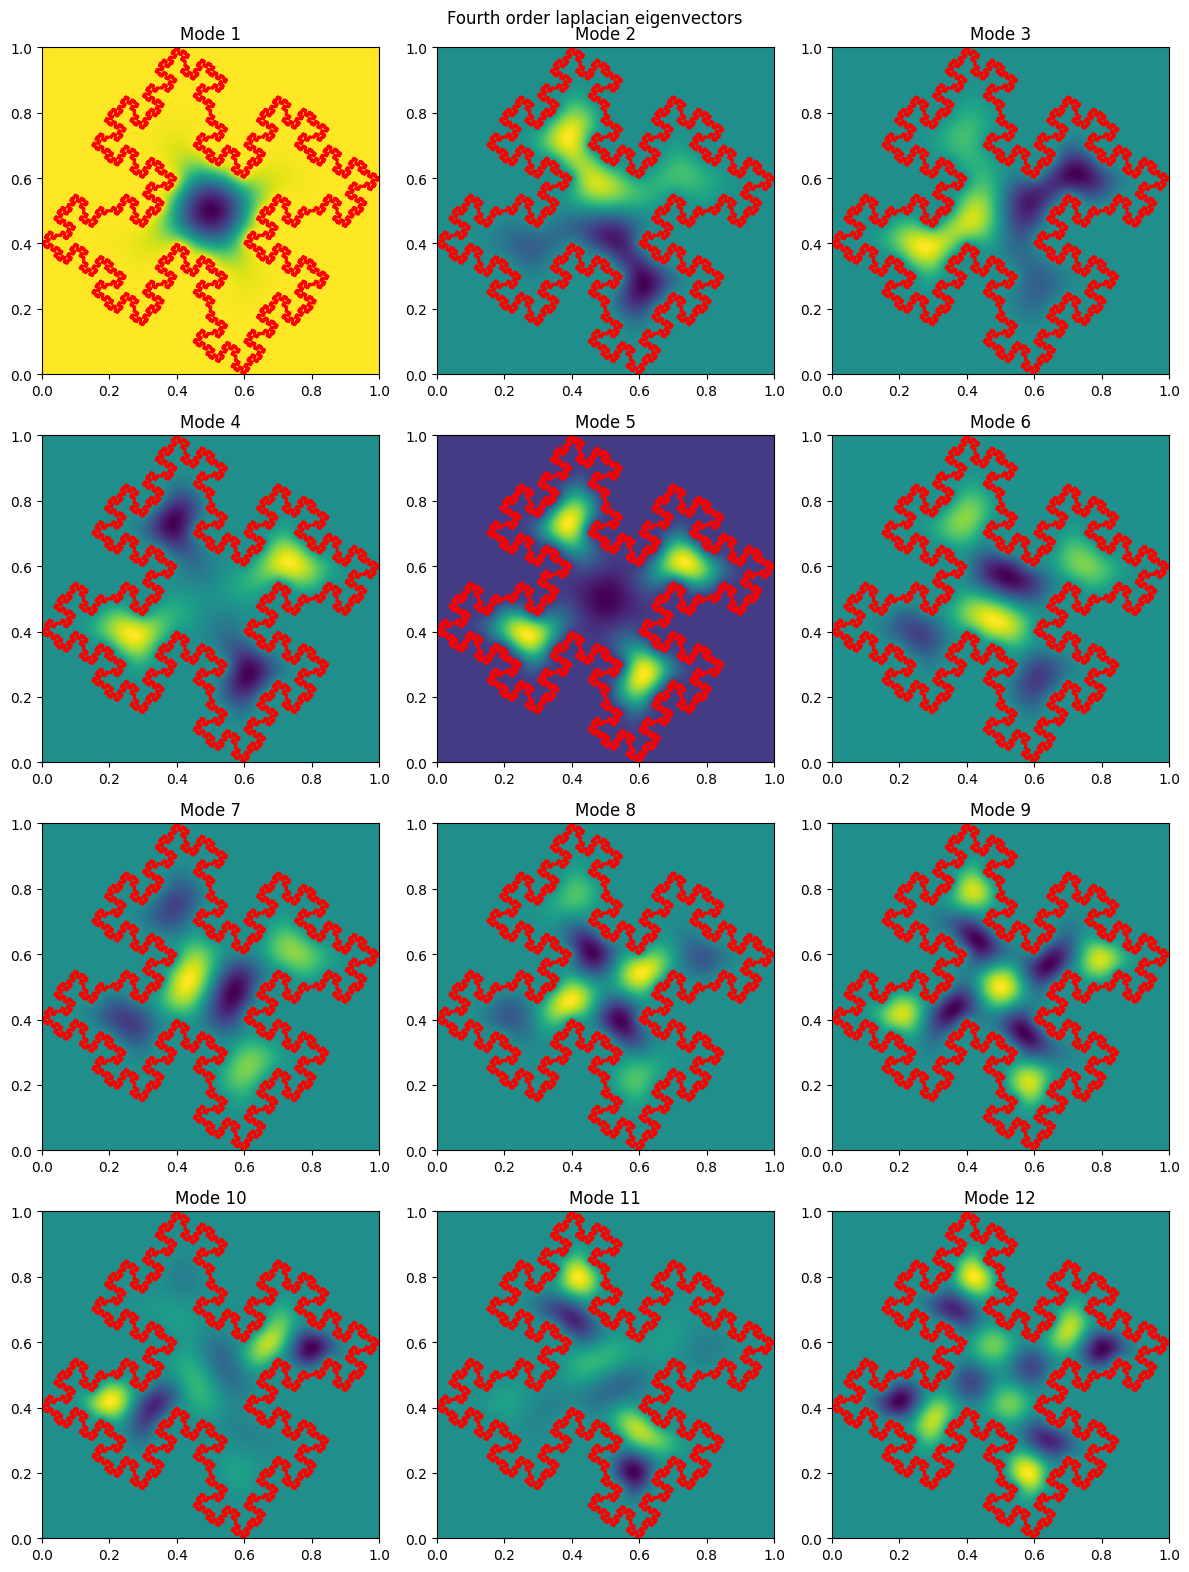

In [73]:
grid_4 = grids[3] 
boundry = boundries[3]
x_collum = grid_4[:,0]
lapliacian_1 = sparse_discrete_laplacian(len(grid_4),len(set(x_collum)), grid_4)
lapliacian_2 = higher_order_laplacian(len(grid_4),len(set(x_collum)), grid_4)
eigenvalues_1, eigenvectors_1 = find_eiegenvalues(lapliacian_1, 21)
eigenvalues_2, eigenvectors_2 = find_eiegenvalues(lapliacian_2, 21)
for i in range(len(eigenvalues_2)):
    print("Second order central difference: ", np.sqrt(eigenvalues_1[i]), "Forth order order central difference: ", np.sqrt(eigenvalues_2[i]), "Difference: ", (np.sqrt(eigenvalues_1[i])-np.sqrt(eigenvalues_2[i])))
plotting_eigenvectors(eigenvectors_2,boundry, "Fourth order laplacian eigenvectors", 12)


In [74]:
def biharmonic_matrix(vector_length, row_length, grid):
    def is_valid_index(idx, num_rows, row_length):
        if idx < 0:
            return False
        row_idx = idx // row_length
        col_idx = idx % row_length
        return row_idx < num_rows and col_idx < row_length


    
    def modify_dic(index_dic, grid, idx):
        #applying the boundary condition is only relevant for points two indexes away
        self_index = 20
        for point_type, point_info in index_dic.items():
            if point_info[1]:
                if grid[point_info[0]][2] == 0:
                    index_dic[point_type][1] = 0 
                    if point_type == "previous_yy" or point_type == "previous_xx" or point_type == "next_xx" or point_type == "next_yy":
                        self_index += 1
        return self_index

    num_rows = vector_length // row_length
    biharmonic = lil_matrix((vector_length, vector_length))
    
    for index in range(len(grid)):
        if grid[index, 2] == 1:
            next_x = index + 1
            next_y = index + row_length
            next_xx = index + 2
            next_yy = index + 2 * row_length
            previous_x = index - 1
            previous_y = index - row_length
            previous_xx = index - 2
            previous_yy = index - 2 * row_length
            pos_x_pos_y = index + 1 + row_length
            pos_x_neg_y = index + 1 - row_length
            neg_x_pos_y = index - 1 + row_length
            neg_x_neg_y = index - 1 - row_length
            
            valid_indexes = {
                'next_x': [next_x, is_valid_index(next_x,  num_rows, row_length), -8],
                'next_y': [next_y, is_valid_index(next_y, num_rows, row_length), -8],
                'next_xx': [next_xx, is_valid_index(next_xx, num_rows, row_length), 1],
                'next_yy': [next_yy, is_valid_index(next_yy, num_rows, row_length), 1],
                'previous_x': [previous_x, is_valid_index(previous_x, num_rows, row_length), -8],
                'previous_y': [previous_y, is_valid_index(previous_y, num_rows, row_length), -8],
                'previous_xx': [previous_xx, is_valid_index(previous_xx, num_rows, row_length), 1],
                'previous_yy': [previous_yy, is_valid_index(previous_yy, num_rows, row_length), 1],
                'pos_x_pos_y': [pos_x_pos_y, is_valid_index(pos_x_pos_y, num_rows, row_length), 2],
                'pos_x_neg_y': [pos_x_neg_y, is_valid_index(pos_x_neg_y, num_rows, row_length), 2],
                'neg_x_pos_y': [neg_x_pos_y, is_valid_index(neg_x_pos_y, num_rows, row_length), 2],
                'neg_x_neg_y': [neg_x_neg_y, is_valid_index(neg_x_neg_y, num_rows, row_length), 2],
            }
            self_index = modify_dic(valid_indexes, grid, index)
            biharmonic[index, index] = self_index
            for points in valid_indexes.values():
                if points[1]:
                    biharmonic[index, points[0]] = points[2]
    return biharmonic.tocsr()

In [ ]:
grid_3 = grids[3]
x_collum = grid_3[:,0]
biharmonic = biharmonic_matrix(len(grid_3),len(set(x_collum)), grid_3)
laplacian = sparse_discrete_laplacian(len(grid_3),len(set(x_collum)), grid_3 )
print("Done with biharmonic matrix")
eigenvalues_3, eigenvectors_3 = find_eiegenvalues(biharmonic, 12, "SM")
eigenvalues_2, eigenvectors_2 = find_eiegenvalues(sparse_laplacian, 12, "SM")
for i in range(len(eigenvalues_3)):
    print("Biharmonic: ", eigenvalues_3[i], "Laplacian: ", eigenvalues_2[i], "Forth order laplacian: ", eigenvalues_3[i])
plotting_eigenvectors(eigenvectors_3, boundries[3],"Biharmonic eigenvectors", 12)
comparision_list = eigenvectors_2[:,2]
combined_columns = np.c_[comparision_list, eigenvectors_2[:,8], eigenvectors_3[:, 2], eigenvectors_3[:, 8]]
print(combined_columns.shape) #this needs to be done someetime
plotting_eigenvectors(combined_columns,boundries[3], "Biharmonic vs laplacian", 4)


Done with biharmonic matrix
